In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from fastseg import MobileV3Small, MobileV3Large
from fastseg.image.colorize import colorize, blend
from dataloader import UROBDataset
import torchvision.transforms as transforms
import torchvision
import cv2
from PIL import Image
from tqdm import tqdm
from utils import *
from lovacs_losses import lovasz_softmax
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda:0'
if not torch.cuda.is_available():
    device = 'cpu'

print(device)

cuda:0


In [3]:
# dataset config
label_mapping = {
    2 : 1, # car,
    3: 1,
    7: 1
}
ignore_label = 10
unique_labels = [0] + [label_mapping[key] for key in label_mapping.keys()]
label_names = ['other', 'rb_car']

# model save paths
model_save_path = './experiments/init_test/model.pt'
model_checkpoint_save_path = './experiments/init_test/checkpoint.pt'

# tensorboard logging
#tb_log_save_path = './experiments/init_test/log'
writer = SummaryWriter() # uncomment for tensorboard

# construct the dataset
target_shape = [512, 1024]
train_dataset = UROBDataset(filenames_file='./experiments/init_test/train_filenames.pkl', target_img_shape=target_shape, label_mapping=label_mapping, ignore_label=ignore_label)
val_dataset = UROBDataset(filenames_file='./experiments/init_test/val_filenames.pkl', target_img_shape=target_shape, label_mapping=label_mapping, ignore_label=ignore_label)
batch_size = 2

# construct the dataloader
transform = transforms.Compose([
    transforms.RandomPerspective(),
    transforms.RandomAutocontrast(),
    transforms.RandomErasing()
])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                          shuffle=True, num_workers=1)

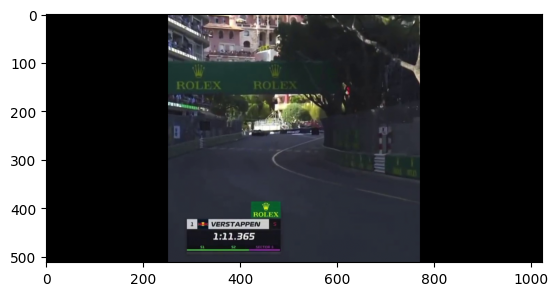

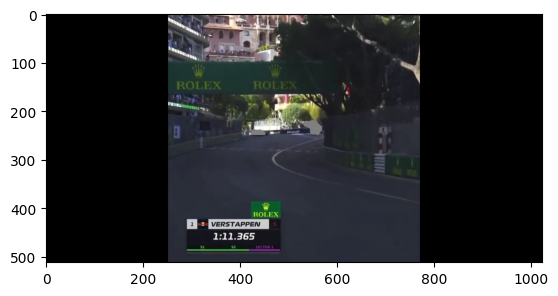

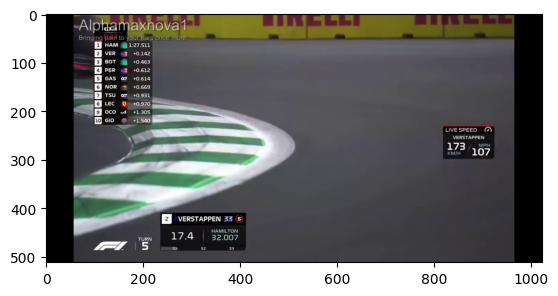

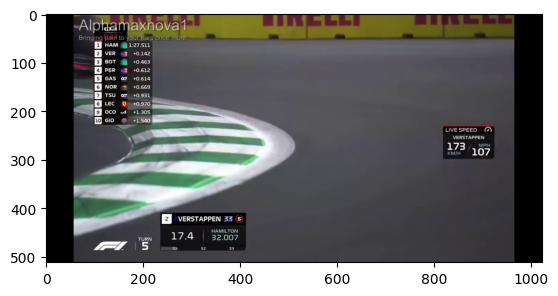

In [4]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
for i in range(images.shape[0]):
    image = images[i, :, :, :]
    label = labels[i, :, :]
    seg_image = image.clone()
    seg_image[:, label==1] = 0
    imshow(image)
    imshow(seg_image)


In [5]:

# define model and optimizer
learning_rate = 1e-3
weight_decay = learning_rate * 1e-2
num_epoch = 20

model = MobileV3Large(num_classes=2)
model = model.to(device=device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.9)

# CE loss
#criterion = torch.nn.CrossEntropyLoss(reduction="none", weight=None, ignore_index=ignore_label)

# lovasc softmax
def criterion(outputs, labels):
    probas = F.softmax(outputs, dim=1)
    loss = lovasz_softmax(probas, labels, ignore=ignore_label) + F.cross_entropy(outputs, labels, ignore_index=ignore_label, reduction='none').mean()
    return loss

In [6]:

best_val_miou = -torch.inf
total_iter = 0

for epoch in range(num_epoch):
    pbar = tqdm(total=len(train_loader))
    model.train()
    for iter, data in enumerate(train_loader):
        X_trn, y_trn = data
        # TODO() augmentation to the dataloader

        # augment the data
        if torch.rand(1).item() > 0.5:
            X_trn = transform(X_trn)             

        # run through model
        X_trn = X_trn.float().to(device=device)
        y_trn = y_trn.long().to(device=device)
        output = model(X_trn)
        # compute loss
        loss = criterion(output, y_trn)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pbar.set_description(f'epoch: {epoch} | loss: {loss.item():.4f}')
        writer.add_scalar('Loss/Train', loss.item(), total_iter) # uncomment for tensorboard
        
        total_iter += 1
        pbar.update(1)
    pbar.close()
    lr_scheduler.step()


    # validate model
    loss_hist, cls_tp_hist, cls_tn_hist, cls_fp_hist, cls_fn_hist = validate(
        val_dataloader=val_loader,
        model=model,
        criterion=criterion,
        unique_labels = unique_labels,
        device=device,
        visualize=False,
        ignore_label=ignore_label
    )

    # print stats
    loss_mean = loss_hist.mean().item()
    cls_iou = compute_cls_iou(cls_tp=cls_tp_hist, cls_tn=cls_tn_hist, cls_fp=cls_fp_hist, cls_fn=cls_fn_hist)
    miou = cls_iou.mean().item()
    print(f'epoch: {epoch} results: ')
    print(f'loss: {loss_mean}')
    for i  in range(len(label_names)):
        print(f'class {label_names[i]} IoU: {100 * cls_iou[i].item()}%')
    print(f'mIoU: {miou * 100}% / best mIoU: {best_val_miou * 100}%')

    # save progress
    if best_val_miou < miou:
        best_val_miou = miou
        with open(model_save_path, 'wb') as file:
            torch.save(model.state_dict(), file)
    with open(model_checkpoint_save_path, 'wb') as file:
            torch.save(model.state_dict(), file)
        

epoch: 0 | loss: 0.2072: 100%|██████████| 456/456 [04:06<00:00,  1.85it/s]


 ------- VALIDATING ------- 


validating: : 100%|██████████| 101/101 [00:11<00:00,  8.45it/s]


tensor([0.9514, 0.6462, 0.6462, 0.6462])
epoch: 0 results: 
loss: 0.32431548833847046
class other IoU: 95.13746500015259%
class rb_car IoU: 64.61927890777588%
mIoU: 72.24882245063782% / best mIoU: -inf%


epoch: 1 | loss: 0.3085: 100%|██████████| 456/456 [04:08<00:00,  1.84it/s]


 ------- VALIDATING ------- 


validating: : 100%|██████████| 101/101 [00:10<00:00,  9.61it/s]


tensor([0.9648, 0.7107, 0.7107, 0.7107])
epoch: 1 results: 
loss: 0.2843799889087677
class other IoU: 96.48470282554626%
class rb_car IoU: 71.07109427452087%
mIoU: 77.42449641227722% / best mIoU: 72.24882245063782%


epoch: 2 | loss: 0.3006: 100%|██████████| 456/456 [04:08<00:00,  1.83it/s]


 ------- VALIDATING ------- 


validating: : 100%|██████████| 101/101 [00:10<00:00,  9.53it/s]


tensor([0.9700, 0.7482, 0.7482, 0.7482])
epoch: 2 results: 
loss: 0.23438893258571625
class other IoU: 96.99855446815491%
class rb_car IoU: 74.82315301895142%
mIoU: 80.36700487136841% / best mIoU: 77.42449641227722%


epoch: 3 | loss: 0.0065: 100%|██████████| 456/456 [04:10<00:00,  1.82it/s]


 ------- VALIDATING ------- 


validating: : 100%|██████████| 101/101 [00:10<00:00,  9.68it/s]


tensor([0.9663, 0.7273, 0.7273, 0.7273])
epoch: 3 results: 
loss: 0.2792016565799713
class other IoU: 96.63114547729492%
class rb_car IoU: 72.73312211036682%
mIoU: 78.70762348175049% / best mIoU: 80.36700487136841%


epoch: 4 | loss: 0.0812: 100%|██████████| 456/456 [04:13<00:00,  1.80it/s]


 ------- VALIDATING ------- 


validating: : 100%|██████████| 101/101 [00:11<00:00,  8.81it/s]


tensor([0.9665, 0.7333, 0.7333, 0.7333])
epoch: 4 results: 
loss: 0.2508918344974518
class other IoU: 96.6534972190857%
class rb_car IoU: 73.33267331123352%
mIoU: 79.16287779808044% / best mIoU: 80.36700487136841%


epoch: 5 | loss: 0.5238: 100%|██████████| 456/456 [04:18<00:00,  1.76it/s]


 ------- VALIDATING ------- 


validating: : 100%|██████████| 101/101 [00:16<00:00,  6.19it/s]


tensor([0.9551, 0.6653, 0.6653, 0.6653])
epoch: 5 results: 
loss: 0.3150462806224823
class other IoU: 95.50633430480957%
class rb_car IoU: 66.53476357460022%
mIoU: 73.7776517868042% / best mIoU: 80.36700487136841%


epoch: 6 | loss: 0.6089:  37%|███▋      | 170/456 [01:37<02:50,  1.68it/s]

KeyboardInterrupt: 